<a href="https://www.kaggle.com/alperenkaran/visualization-of-world-suicide-rates?scriptVersionId=90122427" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<h1><center>World Death and Suicide Rates</center></h1>
<h1><center> <img src="https://cdn.pixabay.com/photo/2017/09/04/15/51/alkoghol-2714489_1280.jpg" alt="drawing" width="600"/> </center></h1>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(palette='tab10')
from wordcloud import WordCloud
import geopandas

!pip install pycountry_convert
import pycountry_convert as pc
from IPython.display import clear_output
clear_output()

In [2]:
# visualization

def visualize_word_counts(counts, show=True):
    wc = WordCloud(max_font_size=130, min_font_size=25, colormap='tab20', background_color='black', 
                   prefer_horizontal=.95, width=2100, height=700, random_state=0)
    cloud = wc.generate_from_frequencies(counts)
    plt.figure(figsize=(15,12))
    plt.imshow(cloud, interpolation='bilinear')
    plt.axis('off')
    if show:
        plt.show()

# Data cleaning

We first read the csv and look at a few rows.

In [3]:
data = pd.read_csv('../input/suicide-rates-worldwide-20002019/data.csv')
data.head()

,Unnamed: 0,Unnamed: 1,"Probability (%) of dying between age 30 and exact age 70 from any of cardiovascular disease, cancer, diabetes, or chronic respiratory disease","Probability (%) of dying between age 30 and exact age 70 from any of cardiovascular disease, cancer, diabetes, or chronic respiratory disease.1","Probability (%) of dying between age 30 and exact age 70 from any of cardiovascular disease, cancer, diabetes, or chronic respiratory disease.2",Crude suicide rates (per 100 000 population),Crude suicide rates (per 100 000 population).1,Crude suicide rates (per 100 000 population).2
0,Country,Year,Both sexes,Male,Female,Both sexes,Male,Female
1,Afghanistan,2019,35.3 [21.8-49.8],34.4 [21.9-47.9],36.2 [21.7-51.6],4.1 [2.3-7.0],4.6 [2.6-7.9],3.6 [2.0-5.9]
2,Afghanistan,2018,35.4 [21.7-50.1],34.7 [22.0-48.5],36.0 [21.4-51.6],4.1 [2.3-6.8],4.6 [2.6-7.8],3.5 [2.0-5.8]
3,Afghanistan,2017,35.5 [21.7-50.4],35.0 [22.0-49.1],35.9 [21.3-51.7],4.1 [2.3-6.8],4.6 [2.7-7.9],3.4 [2.0-5.7]
4,Afghanistan,2016,35.6 [21.6-50.7],35.1 [22.0-49.4],36.0 [21.2-51.9],4.0 [2.3-6.7],4.4 [2.6-7.4],3.6 [2.1-5.9]


The actual data starts at row 1 (not row 0).

We should create new column names from the column names above, and row 0.

In [4]:
columns = ['Country', 'Year', 
           'ProbDyingBoth','ProbDyingMale','ProbDyingFemale',
           'SuicideBoth','SuicideMale','SuicideFemale']

values = data.iloc[1:,:].values
data = pd.DataFrame(values, columns=columns)

for col in columns[2:]:
    data[col] = data[col].map(lambda x: x.split('[')[0]).astype('float')

In [5]:
data['ProbDying_male_minus_female'] = data['ProbDyingMale'] - data['ProbDyingFemale']
data['Suicide_male_minus_female'] = data['SuicideMale'] - data['SuicideFemale']

In [6]:
data.sample(5)

,Country,Year,ProbDyingBoth,ProbDyingMale,ProbDyingFemale,SuicideBoth,SuicideMale,SuicideFemale,ProbDying_male_minus_female,Suicide_male_minus_female
2274,Namibia,2005,29.7,37.5,23.0,17.8,28.8,7.5,14.5,21.3
44,Algeria,2015,14.3,15.2,13.3,2.7,3.4,2.0,1.9,1.4
840,Cyprus,2019,8.2,10.7,5.7,3.6,6.0,1.3,5.0,4.7
2629,Republic of Korea,2010,10.6,14.9,6.4,34.0,44.9,23.0,8.5,21.9
2776,Saint Vincent and the Grenadines,2003,22.5,24.3,20.7,5.8,10.4,1.1,3.6,9.3


Now it looks much better! But we still have some work to do! Some country names have some extra info like "`Iran (Islamic Republic of)`". We want to correct it.

We also want to find the continent of each country. We'll use `pycountry_convert` library for that purpose.

In [7]:
country_names_correction = {'Bolivia (Plurinational State of)': 'Bolivia', 
                            'Iran (Islamic Republic of)': 'Iran', 
                            'Micronesia (Federated States of)': 'Micronesia', 
                            'Republic of Korea': 'South Korea', 
                            'Venezuela (Bolivarian Republic of)': 'Venezuela'}

continent_code_to_name = {'AS':'Asia', 'SA':'South America', 'NA':'North America', 
                          'EU':'Europe', 'OC':'Oceania', 'AF':'Africa'}

In [8]:
def country_to_continent(country_name):
    if country_name == 'Timor-Leste':
        return 'Asia'
    country_code = pc.country_name_to_country_alpha2(country_name)
    continent_code = pc.country_alpha2_to_continent_code(country_code)
    return continent_code_to_name[continent_code]

In [9]:
data['Country'] = data['Country'].map(country_names_correction).fillna(data['Country'])
data['Continent'] = data['Country'].map(country_to_continent)

In [10]:
countries = {val:df for val, df in data.groupby('Country')} # a dictionary of country names to the data
country_avg = data.groupby('Country').mean().reset_index() # a dataframe of average by country (over the years)

In [11]:
countries['Germany'].head()

,Country,Year,ProbDyingBoth,ProbDyingMale,ProbDyingFemale,SuicideBoth,SuicideMale,SuicideFemale,ProbDying_male_minus_female,Suicide_male_minus_female,Continent
1260,Germany,2019,12.1,15.2,9.0,12.3,18.6,6.2,6.2,12.4,Europe
1261,Germany,2018,12.2,15.3,9.1,12.9,19.2,6.8,6.2,12.4,Europe
1262,Germany,2017,12.1,15.2,9.0,12.6,18.8,6.6,6.2,12.2,Europe
1263,Germany,2016,12.4,15.6,9.2,13.0,19.4,6.8,6.4,12.6,Europe
1264,Germany,2015,12.6,15.9,9.2,13.3,19.5,7.3,6.7,12.2,Europe


# Death and suicide rates by gender

It appears that in almost every country (except for a few), men die more often than women. Furthermore, in every country, men commit suicide more often than women.

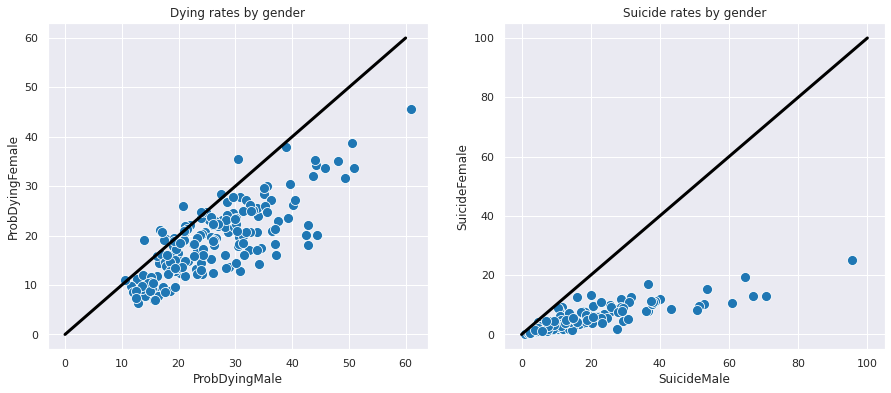

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,6))

ax[0].plot([0,60],[0,60], linewidth=3, color='black')
sns.scatterplot(data=country_avg, x='ProbDyingMale', y='ProbDyingFemale', s=100, ax=ax[0])
ax[0].set_title('Dying rates by gender')

ax[1].plot([0,100],[0,100], linewidth=3, color='black')
sns.scatterplot(data=country_avg, x='SuicideMale', y='SuicideFemale', s=100, ax=ax[1])
ax[1].set_title('Suicide rates by gender')

plt.show()

In [13]:
country_avg.sort_values(by='ProbDying_male_minus_female')

,Country,ProbDyingBoth,ProbDyingMale,ProbDyingFemale,SuicideBoth,SuicideMale,SuicideFemale,ProbDying_male_minus_female,Suicide_male_minus_female
102,Mali,23.645,20.715,26.025,4.470,5.465,3.470,-5.310,1.995
104,Mauritania,16.795,13.865,19.150,3.170,3.990,2.395,-5.285,1.595
71,Haiti,33.225,30.485,35.600,9.795,10.645,8.995,-5.115,1.650
94,Liberia,19.035,16.690,21.050,4.770,5.640,3.870,-4.360,1.770
131,Qatar,18.235,17.130,20.835,7.155,9.185,1.995,-3.705,7.190
...,...,...,...,...,...,...,...,...,...
85,Kazakhstan,31.855,42.830,22.240,30.695,52.625,10.265,20.590,42.360
91,Latvia,25.680,37.080,16.165,24.505,43.325,8.570,20.915,34.755
170,Ukraine,30.450,42.420,20.185,27.905,50.645,8.270,22.235,42.375
134,Russian Federation,31.440,44.315,20.230,39.720,70.605,12.875,24.085,57.730


It appears that 

- In **Mali** (top row), women die more often than men.
- In **Belarus** (bottom row), men die far more often than women.

# Plotting with geopandas

Geopandas sometimes use different country names. We also need to correct them. For example, the country `Bosnia and Herzegovina` appears as `Bosnia and Herz.` in geopandas.

In [14]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

In [15]:
geopandas_countryname_correction = {'Bosnia and Herz.': 'Bosnia and Herzegovina', 
                                    'Brunei': 'Brunei Darussalam', 
                                    'Central African Rep.': 'Central African Republic', 
                                    'Dem. Rep. Congo': 'Democratic Republic of the Congo', 
                                    'Dominican Rep.': 'Dominican Republic', 
                                    'Eq. Guinea': 'Equatorial Guinea', 
                                    'eSwatini': 'Eswatini', 
                                    'Laos': "Lao People's Democratic Republic", 
                                    'Macedonia': 'North Macedonia', 
                                    'Moldova': 'Republic of Moldova', 
                                    'Russia': 'Russian Federation', 
                                    'United Kingdom': 'United Kingdom of Great Britain and Northern Ireland', 
                                    'Tanzania': 'United Republic of Tanzania', 
                                    'Vietnam': 'Viet Nam', 
                                    'Syria': 'Syrian Arab Republic', 
                                    'S. Sudan': 'South Sudan', 
                                    'Solomon Is.': 'Solomon Islands', 
                                    'North Korea': "Democratic People's Republic of Korea"}

In [16]:
world['Country'] = world['name'].map(geopandas_countryname_correction).fillna(world['name'])
world_merged = world.merge(country_avg, on='Country', how='left')

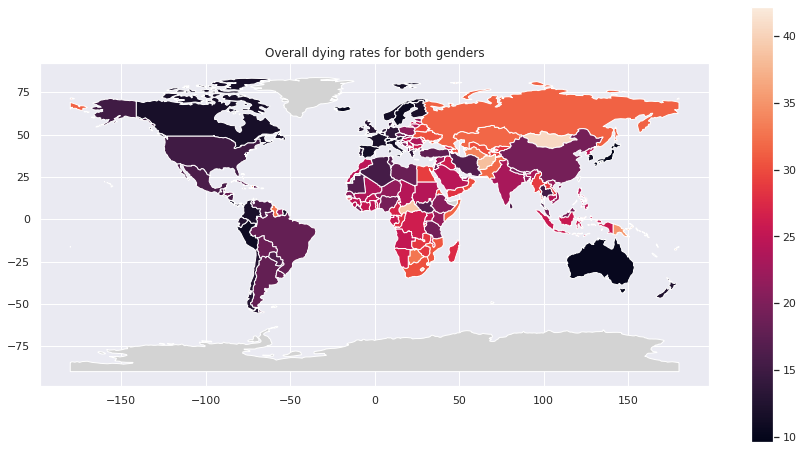

In [17]:
world_merged.plot(column='ProbDyingBoth', legend=True, figsize=(15, 8), missing_kwds={"color": "lightgrey","label": "Missing values",},)
plt.title('Overall dying rates for both genders')
plt.show()

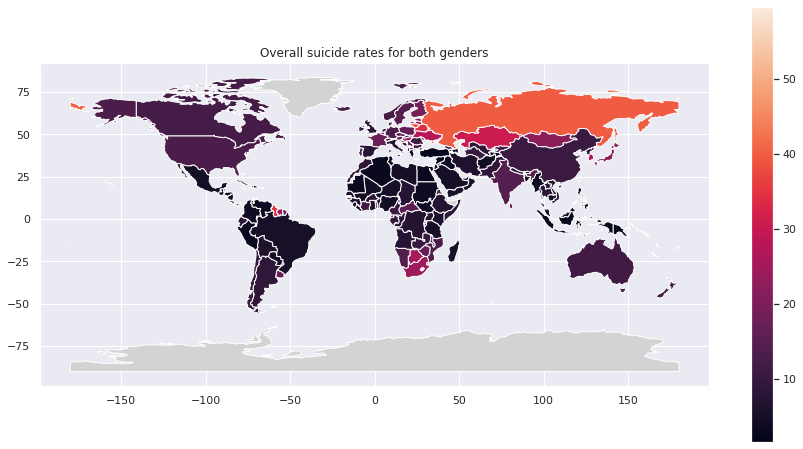

In [18]:
world_merged.plot(column='SuicideBoth', legend=True, figsize=(15, 8), missing_kwds={"color": "lightgrey","label": "Missing values",},)
plt.title('Overall suicide rates for both genders')
plt.show()

The above two plots show that
- In **Africa** and **South America**, people die more often, but they do not commit suicide. 
- In **Canada**, **Australia** and **nordic countries**, people don't die often, but the suicide rates are somewhat higher.
- Dying and suicide rates are both high in **Russia**.

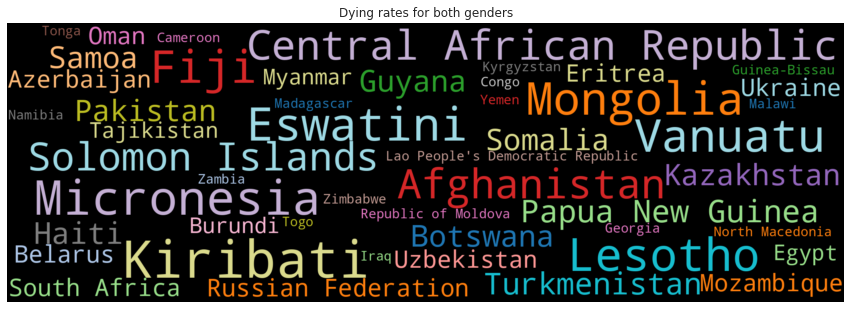

In [19]:
visualize_word_counts(country_avg.set_index('Country')['ProbDyingBoth'].to_dict(), show=False)
plt.title('Dying rates for both genders')
plt.show()

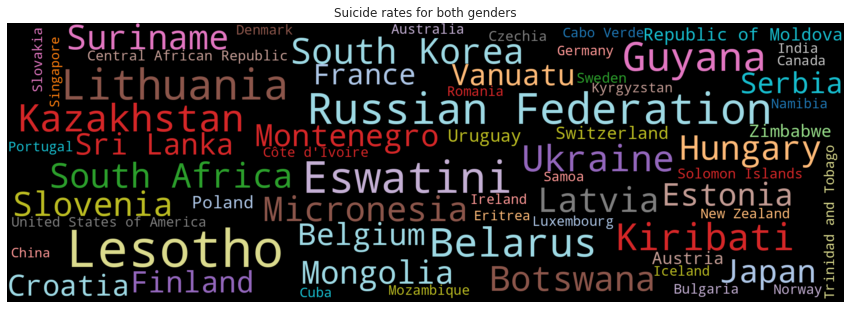

In [20]:
visualize_word_counts(country_avg.set_index('Country')['SuicideBoth'].to_dict(), show=False)
plt.title('Suicide rates for both genders')
plt.show()

# Yearly changes

Let's look at the Top 10 countries with highest overall death and suicide rates. Are the rates increasing, decreasing or constant?

In [21]:
top10_death = country_avg.sort_values('ProbDyingBoth', ascending=False).head(10)
top10_death

,Country,ProbDyingBoth,ProbDyingMale,ProbDyingFemale,SuicideBoth,SuicideMale,SuicideFemale,ProbDying_male_minus_female,Suicide_male_minus_female
87,Kiribati,53.245,60.920,45.725,30.085,51.305,9.530,15.195,41.775
107,Micronesia,44.930,50.625,38.815,25.190,38.535,11.400,11.810,27.135
55,Eswatini,42.175,50.825,33.625,41.000,64.500,19.495,17.200,45.005
93,Lesotho,41.130,48.090,35.045,59.570,95.585,25.235,13.045,70.350
108,Mongolia,40.550,49.350,31.630,21.805,36.045,7.790,17.720,28.255
177,Vanuatu,40.210,45.750,33.670,18.750,29.180,7.930,12.080,21.250
57,Fiji,39.745,44.050,35.280,9.645,12.850,6.335,8.770,6.515
31,Central African Republic,38.990,44.275,34.330,15.370,23.985,6.955,9.945,17.030
0,Afghanistan,38.445,38.950,37.920,4.460,4.835,4.060,1.030,0.775
148,Solomon Islands,38.160,43.640,31.985,14.945,27.560,1.815,11.655,25.745


In [22]:
top10_suicide = country_avg.sort_values('SuicideBoth', ascending=False).head(10)
top10_suicide

,Country,ProbDyingBoth,ProbDyingMale,ProbDyingFemale,SuicideBoth,SuicideMale,SuicideFemale,ProbDying_male_minus_female,Suicide_male_minus_female
93,Lesotho,41.130,48.090,35.045,59.570,95.585,25.235,13.045,70.350
55,Eswatini,42.175,50.825,33.625,41.000,64.500,19.495,17.200,45.005
134,Russian Federation,31.440,44.315,20.230,39.720,70.605,12.875,24.085,57.730
96,Lithuania,23.370,34.230,14.185,37.980,66.970,12.990,20.045,53.980
70,Guyana,32.790,35.585,30.060,34.575,53.755,15.425,5.525,38.330
14,Belarus,29.670,42.795,18.135,34.040,60.755,10.685,24.660,50.070
85,Kazakhstan,31.855,42.830,22.240,30.695,52.625,10.265,20.590,42.360
87,Kiribati,53.245,60.920,45.725,30.085,51.305,9.530,15.195,41.775
170,Ukraine,30.450,42.420,20.185,27.905,50.645,8.270,22.235,42.375
151,South Korea,11.250,15.695,6.980,26.750,36.445,16.980,8.715,19.465


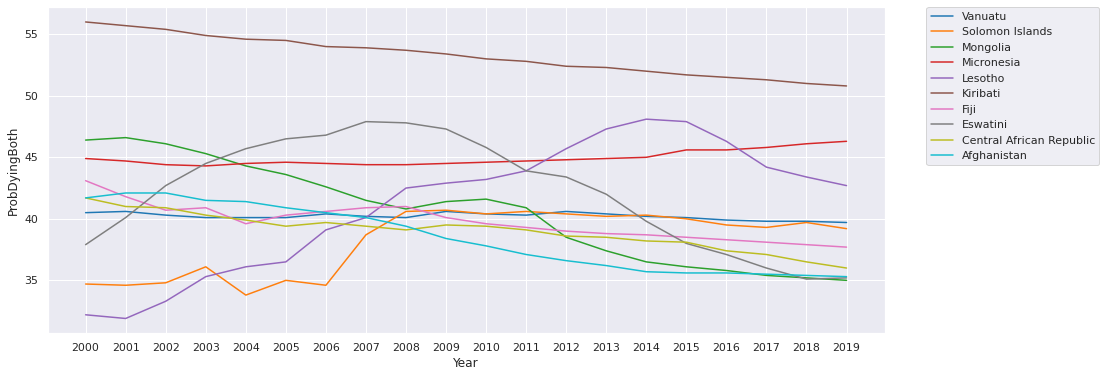

In [23]:
data_top10_death = data[data.Country.isin(top10_death['Country'])].iloc[::-1,:] # the iloc part reverses the dataframe, so 2000 comes before 2019

plt.figure(figsize=(15,6))
sns.lineplot(data=data_top10_death, x='Year', y='ProbDyingBoth', hue='Country')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

There is no general trend for all Top 10 countries. 

However, when we look at the plots separately, it is easy to catch some patterns. 

For example, in Kiribati and Afganistan, the death rates are decreasing. In Eswatini, the death rates made a peak around 2007, then it started decreasing rapidly.

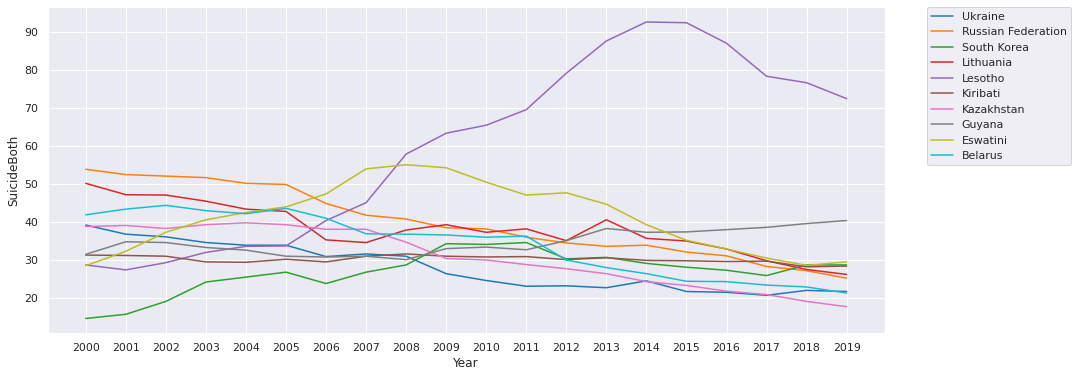

In [24]:
data_top10_suicide = data[data.Country.isin(top10_suicide['Country'])].iloc[::-1,:] # the iloc part reverses the dataframe, so 2000 comes before 2019

plt.figure(figsize=(15,6))
sns.lineplot(data=data_top10_suicide, x='Year', y='SuicideBoth', hue='Country')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

Many countries with highest suicide rates follow a somewhat constant or slightly decreasing trend over the years. 

An exception Lesotho. In this country, suicide rates made a peak at 2014, and now it is decreasing again.